In [156]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from sklearn.manifold import TSNE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [93]:
class multiLayerPerceptron(nn.Module):
  def __init__(self, ip_size, op_size, hidden_layer1, hidden_layer2):
    super().__init__()
    self.ip_size = ip_size
    self.lin1 = nn.Linear(ip_size, hidden_layer1)
    self.lin2 = nn.Linear(hidden_layer1, hidden_layer2)
    self.lin3 = nn.Linear(hidden_layer2, op_size)

  def forward(self, x):
    x = x.view(-1, self.ip_size)
    x = F.relu(self.lin1(x))
    x = F.relu(self.lin2(x))
    x = self.lin3(x)
    
    return F.softmax(x, dim=1)

In [94]:
def fit(model, mnist_train, epochs=1, lr=0.001):
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    for epoch in range(epochs):
        print(f"<-------------------------- epoch: {epoch}--------------------------->")
        train_loss = 0
        for i in tqdm(range(len(mnist_train))):
            x, y = mnist_train[i]

            # need to convert the label to float to avoid type mismatch in loss_fn
            y = F.one_hot(torch.tensor(y), num_classes=10).float()
            y_pred = model(x).view(10)
            
            # print("\nx shape:", x.shape, "y shape:", y.shape, "y_pred shape:",  y_pred.shape)
            # print(y, y_pred)

            loss = loss_fn(y_pred, y)
            train_loss = loss

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if i % 20000 == 0:
                print("\niter:", i, ", training loss:", train_loss)

In [153]:
def predict(model, data):
    y_hat = []
    y_true = []
    with torch.no_grad():
        for i in tqdm(range(len(data))):
            x, y = data[i]
            y_hat.append(model(x).argmax().item())
            y_true.append(y)

    y_hat = np.array(y_hat)
    y_true = np.array(y_true)

    return y_hat, y_true

In [102]:
def plot_TSNE(model, mnist_test):
    model.eval()
    outputs = []
    labels = []
    with torch.no_grad():
        for x, y in mnist_test:
            x = x.view(-1, 28*28)
            output = F.relu(model.lin2(F.relu(model.lin1(x))))
            outputs.append(output)
            labels.append(y)

    outputs = torch.cat(outputs, dim=0)
    outputs = outputs.view(-1, 20)
    labels = np.array(labels)

    # Apply t-SNE to reduce the dimensionality to 2D
    tsne = TSNE(n_components=2, random_state=42)
    tsne_output = tsne.fit_transform(outputs)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_output[:, 0], tsne_output[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.legend(handles=scatter.legend_elements()[0], labels=[str(i) for i in range(10)])
    plt.title('t-SNE Visualization of MLP Output (20 Neurons)')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.colorbar(scatter, ticks=range(10))
    plt.grid(True)
    plt.show()

In [97]:
def plot_TSNE_3D(model, mnist_test, text):
    model.eval()
    outputs = []
    labels = []
    with torch.no_grad():
        for x, y in mnist_test:
            x = x.view(-1, 28*28)
            output = F.relu(model.lin2(F.relu(model.lin1(x))))
            outputs.append(output)
            labels.append(y)

    outputs = torch.cat(outputs, dim=0)
    outputs = outputs.view(-1, 20)
    labels = np.array(labels)

    # Apply t-SNE to reduce the dimensionality to 2D
    tsne = TSNE(n_components=3, random_state=42)
    tsne_output = tsne.fit_transform(outputs)

    ax = plt.figure(figsize=(10, 8)).add_subplot(111, projection='3d')
    ax.scatter(tsne_output[:, 0], tsne_output[:, 1],tsne_output[:,2], s= 5, c=labels, cmap='Spectral')
    plt.title(f'Visualizing {text} MNIST through t-SNE in 3D', fontsize=24);
    plt.show()

In [98]:
# Load MNIST dataset
mnist_train = torchvision.datasets.MNIST('datasets', train=True, transform=torchvision.transforms.ToTensor(), download=True)
mnist_test = torchvision.datasets.MNIST('datasets', train=False, transform=torchvision.transforms.ToTensor(), download=True)

In [179]:
model = multiLayerPerceptron(ip_size=28*28, op_size=10, hidden_layer1=30, hidden_layer2=20)
model

multiLayerPerceptron(
  (lin1): Linear(in_features=784, out_features=30, bias=True)
  (lin2): Linear(in_features=30, out_features=20, bias=True)
  (lin3): Linear(in_features=20, out_features=10, bias=True)
)

### Before Training

In [100]:
y_hat_mlp, y_true_mlp = predict(model, mnist_test)

corr_pred = len(np.where(y_hat_mlp == y_true_mlp)[0])
print("Number of correct predictions: ", corr_pred)
accuracy = (corr_pred / len(y_true_mlp)) * 100
print("Accuracy without training: ", accuracy, "%")

100%|██████████| 10000/10000 [00:01<00:00, 8034.69it/s]

Number of correct predictions:  1142
Accuracy without training:  11.42 %


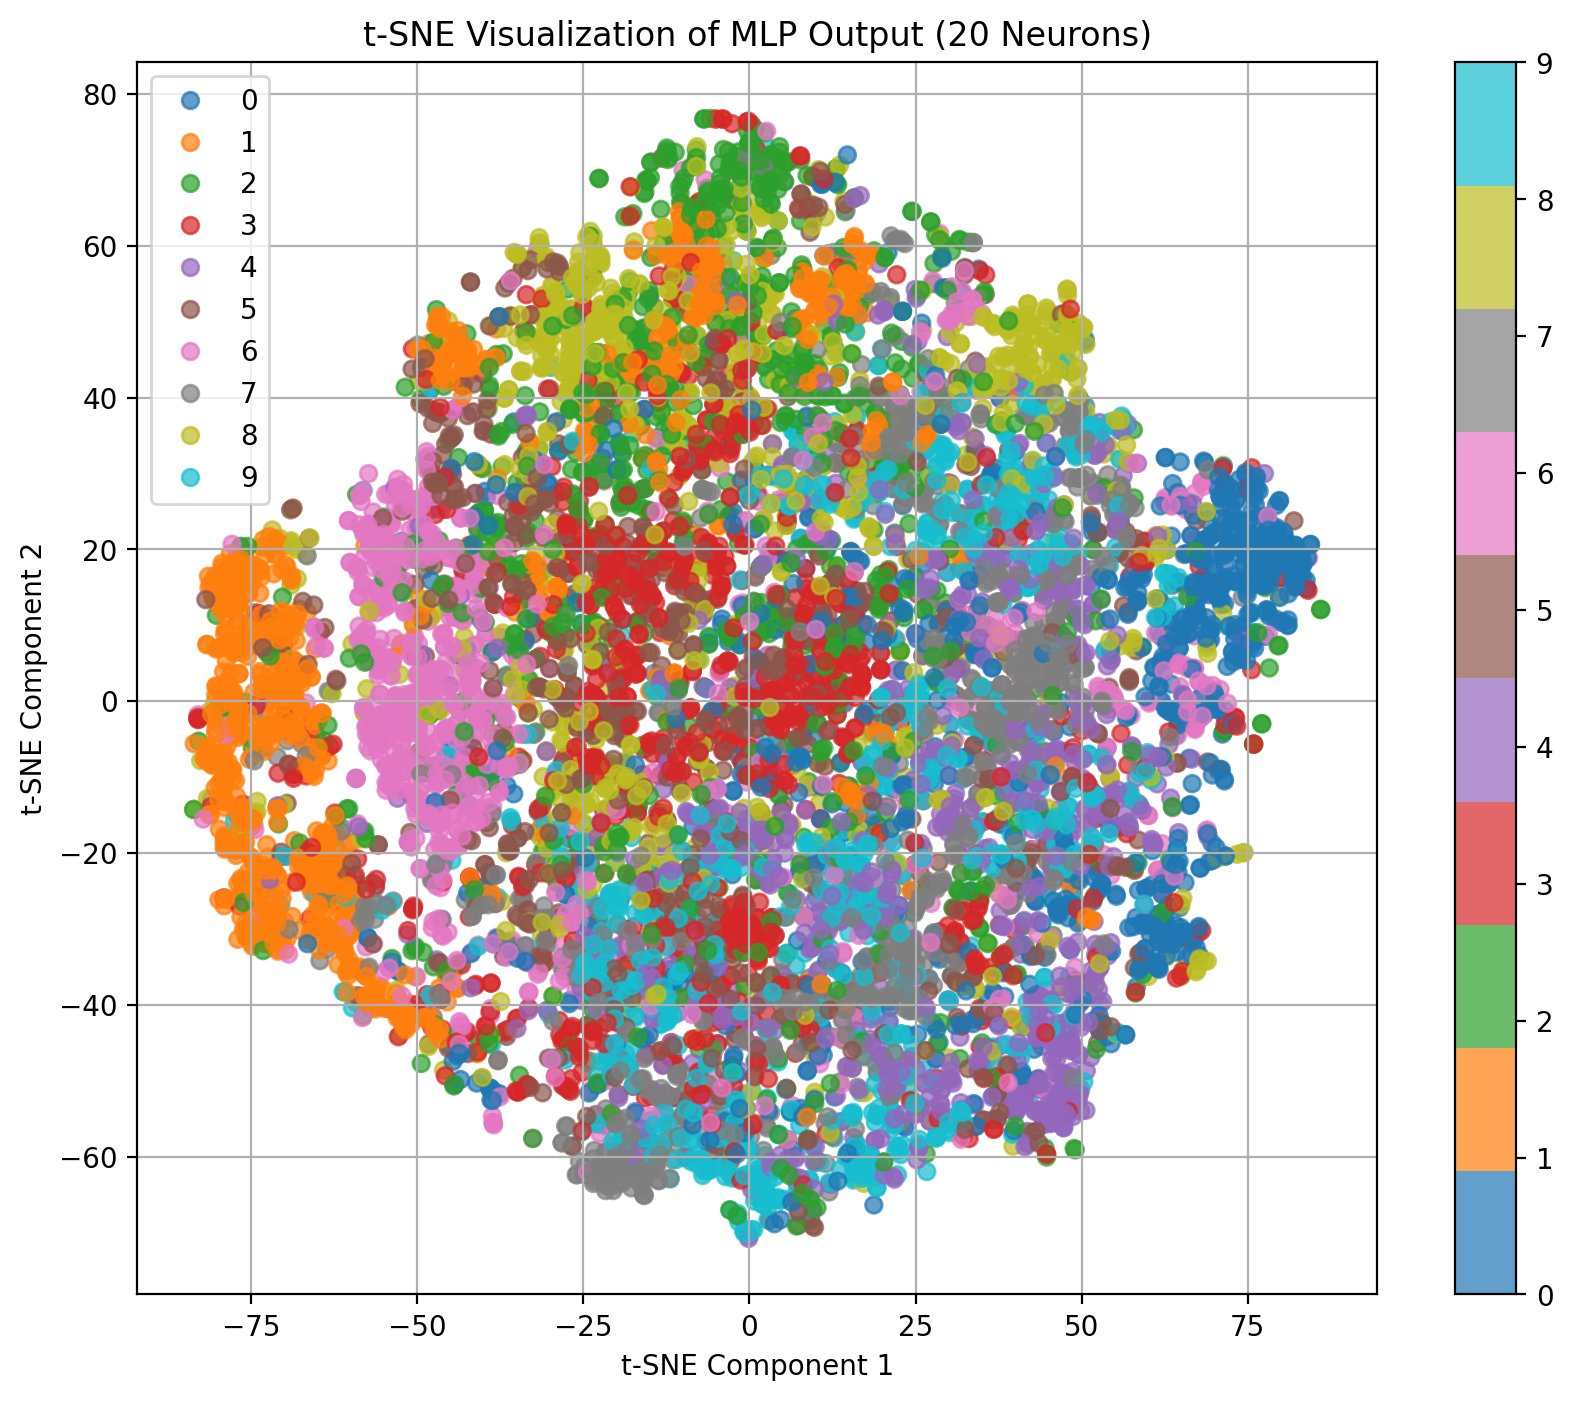

In [103]:
plot_TSNE(model, mnist_test)

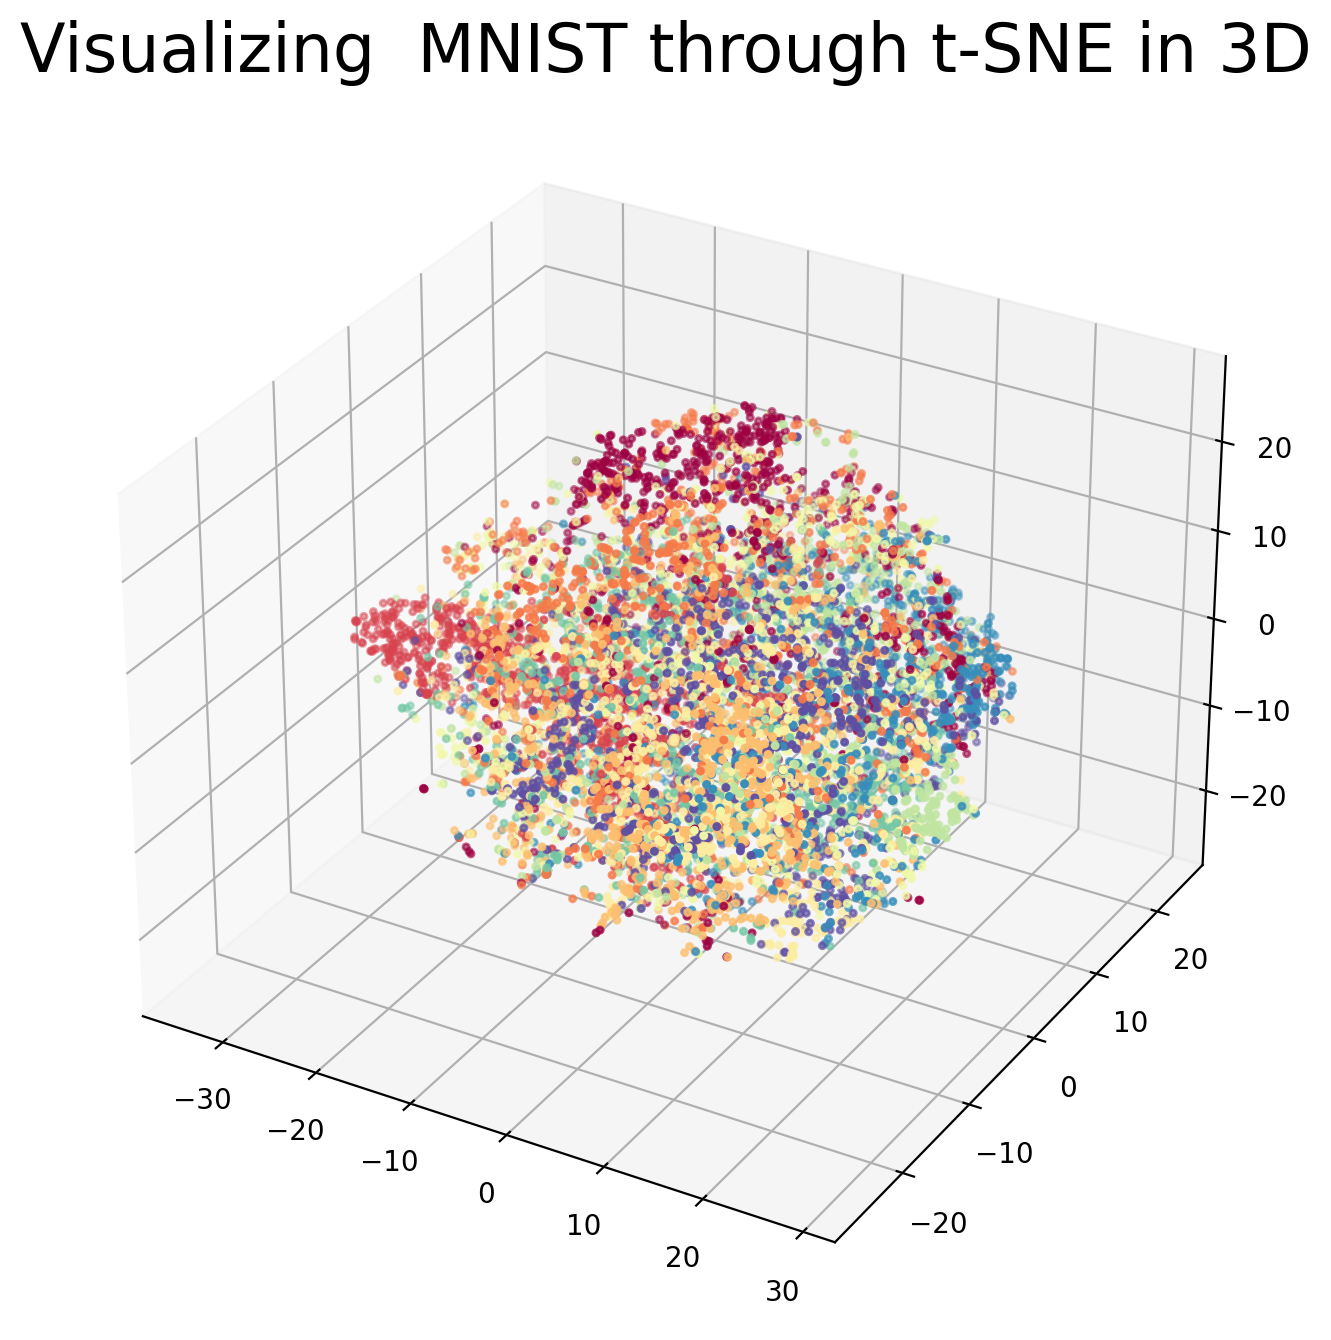

In [180]:
plot_TSNE_3D(model, mnist_test, "")

### After Training

In [183]:
fit(model, mnist_train, epochs=1, lr=0.001)

<-------------------------- epoch: 0--------------------------->


  0%|          | 45/60000 [00:00<02:16, 439.18it/s]


iter: 0 , training loss: tensor(1.4613, grad_fn=<DivBackward1>)


 33%|███▎      | 20018/60000 [00:49<01:46, 375.18it/s]


iter: 20000 , training loss: tensor(1.4612, grad_fn=<DivBackward1>)


 67%|██████▋   | 40077/60000 [01:40<00:59, 335.37it/s]


iter: 40000 , training loss: tensor(1.4612, grad_fn=<DivBackward1>)


100%|██████████| 60000/60000 [02:35<00:00, 385.51it/s]


In [184]:
y_hat_mlp, y_true_mlp = predict(model, mnist_test)

corr_pred = len(np.where(y_hat_mlp == y_true_mlp)[0])
print("Number of correct predictions: ", corr_pred)
accuracy = (corr_pred / len(y_true_mlp)) * 100
print("Accuracy after training: ", accuracy, "%")

100%|██████████| 10000/10000 [00:02<00:00, 3704.29it/s]


Number of correct predictions:  9384
Accuracy after training:  93.84 %


In [106]:
torch.save(model.state_dict(), 'checkpoint.pth')

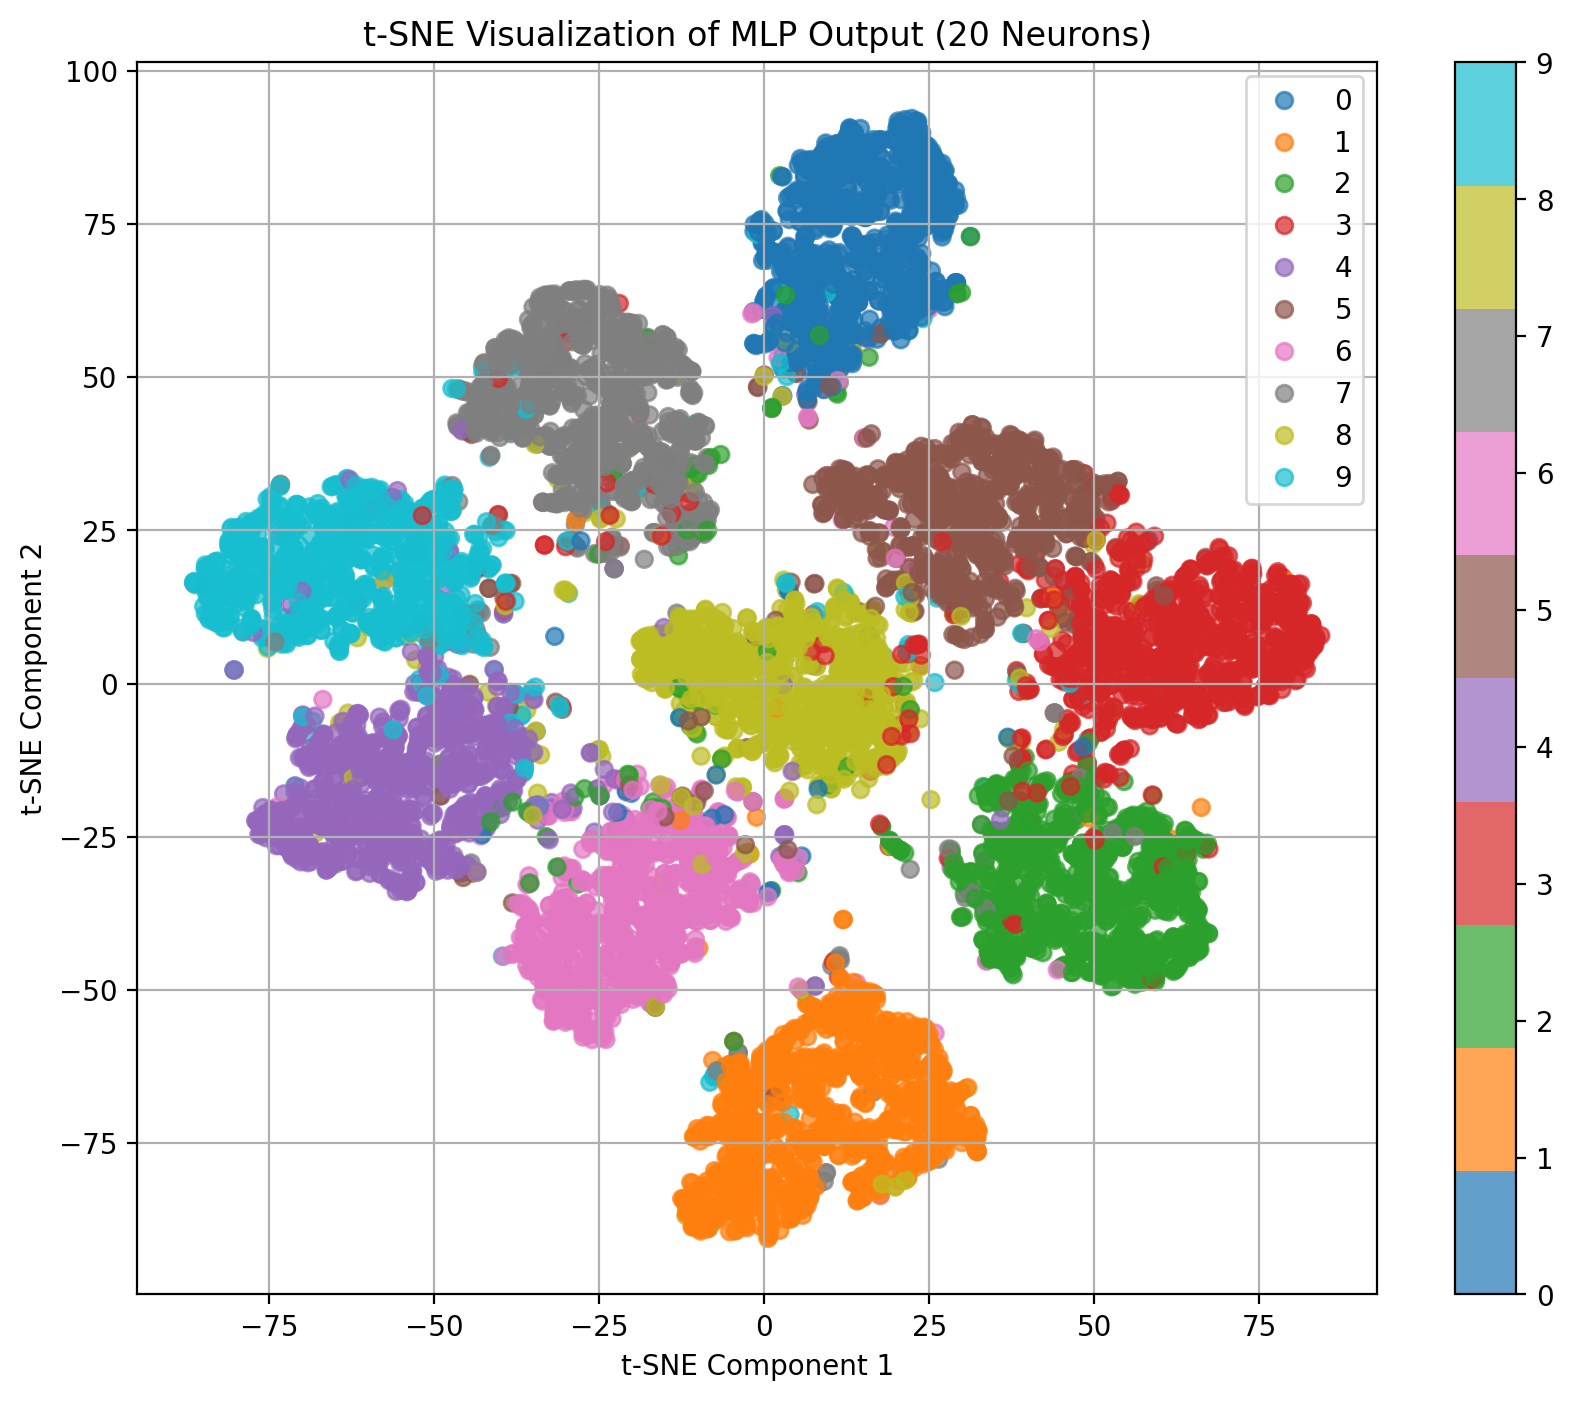

In [107]:
plot_TSNE(model, mnist_test)

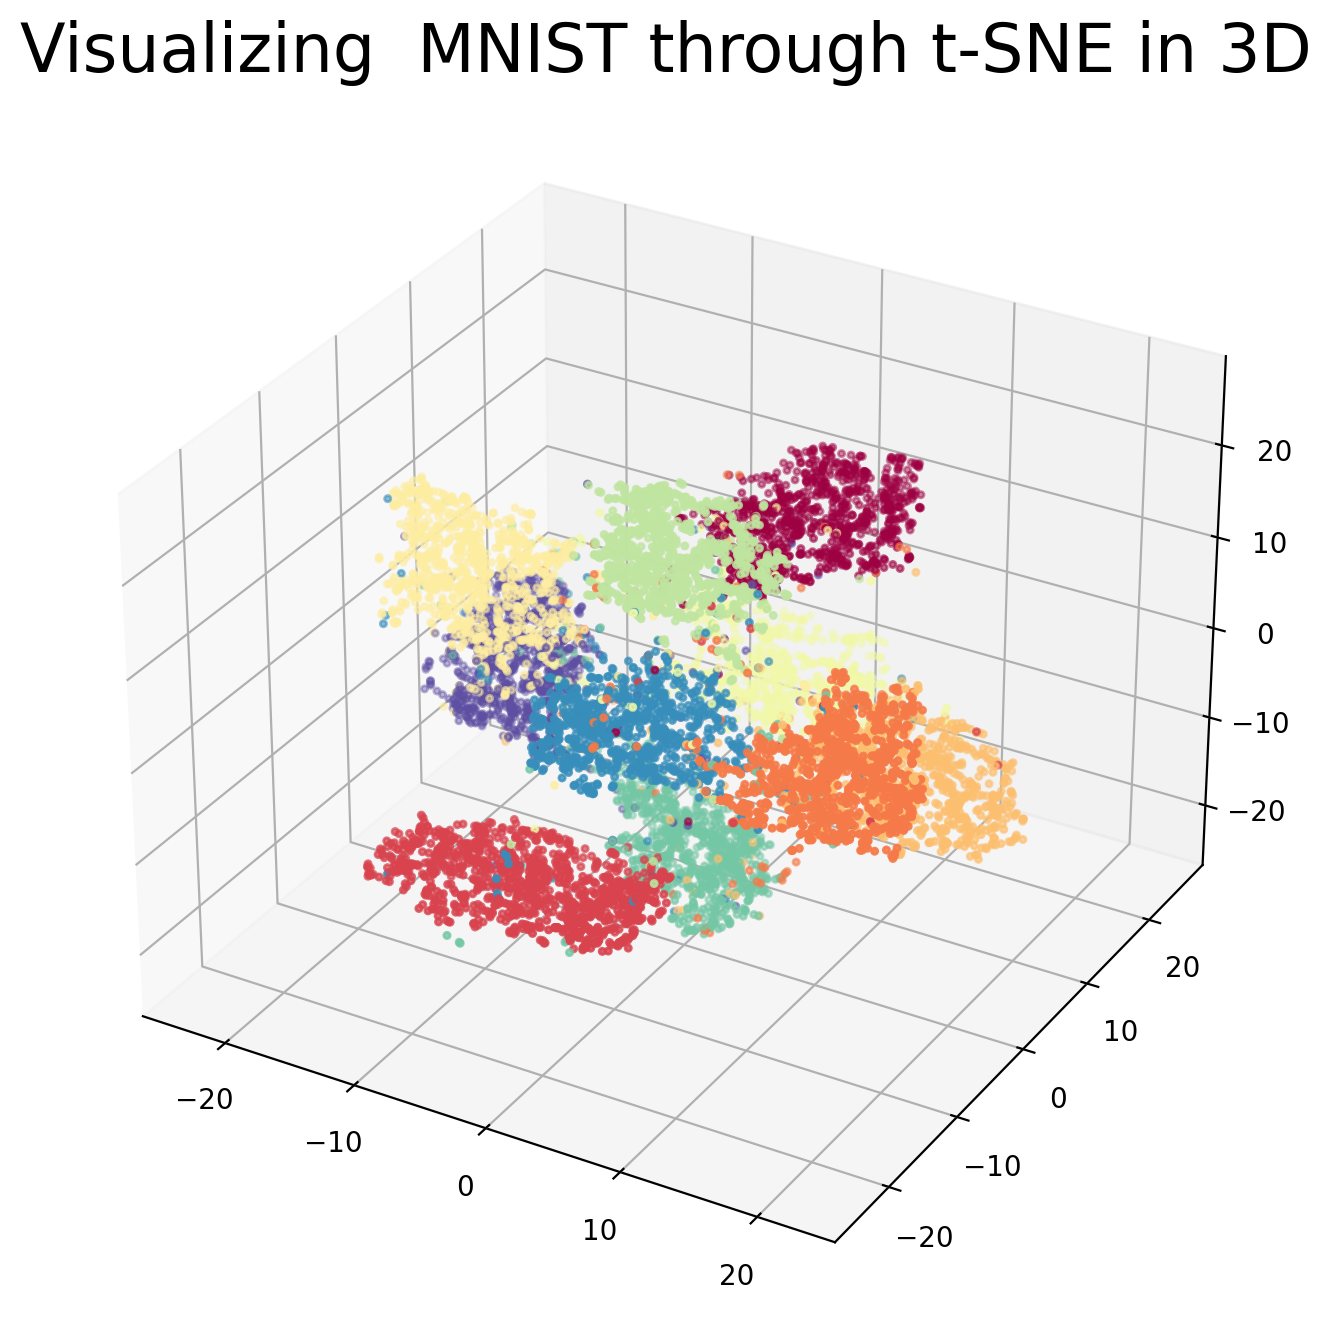

In [108]:
plot_TSNE_3D(model, mnist_test, text="")

### Multi-Class Logistic Regression

In [109]:
def create_dataset(data):
    X, y = [], []
    for i in range(len(data)):
        X_ten, y_ten = data[i]
        X_ten = X_ten.view(28*28)

        X.append(X_ten)
        y.append(y_ten)
        
    # X = torch.stack(X)
    # X = X.view(-1, 28*28)
    # print(X.shape)

    # initially x is a list of tensors, so we need to stack them and then reshape them
    return torch.stack(X).view(-1, 28*28), y;


X_train, y_train = create_dataset(mnist_train)
X_test, y_test = create_dataset(mnist_test)

In [110]:
clf = LogisticRegression(multi_class='multinomial', random_state=0, max_iter=70000).fit(X_train, y_train)

In [111]:
LR_predictions = clf.predict(X_test)
clf.score(X_test, y_test)

0.9261

### Radom Forest

In [61]:
from itertools import product

hyperparameters = {}
hyperparameters['max_depth'] = [1,2,3,4,5,6,7,8,9,10]
hyperparameters['criteria_values'] = ['gini', 'entropy']

# Initialize a list to store the optimal hyperparameters for each validation set
optimal_hyperparameters = {}
test_accuracies = []

# Set the number of subsets and iterations
num_subsets = 5

# Make a pandas dataframe with columns as the hyperparameters, subset number, and validation accuracy
hyperparameters_df = pd.DataFrame(columns=['max_depth', 'criterion', 'subset', 'validation accuracy'])

X_train_val, y_train_val = X_train, y_train

# Iterate over the subsets
for i in range(num_subsets):
    # Split the data into training and validation sets
    X_train_subset, X_val_subset, y_train_subset, y_val_subset = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=i)
    
    # Initialize variables to store the best hyperparameters and accuracy for the current subset
    best_accuracy = 0
    best_hyperparameters = {}
    
    # Iterate over the hyperparameter values

    # for max_depth in hyperparameters['max_depth']:
    #     for criterion in hyperparameters['criteria_values']:
    
    for max_depth, criterion in tqdm(product(hyperparameters['max_depth'], hyperparameters['criteria_values'])):
        # Initialize and train the model with the current hyperparameters
        rf_classifier = RandomForestClassifier(max_depth=max_depth, criterion=criterion, random_state=42)
        rf_classifier.fit(X_train_subset, y_train_subset)
        
        # Evaluate the model on the validation set
        val_accuracy = rf_classifier.score(X_val_subset, y_val_subset)
        hyperparameters_df.loc[len(hyperparameters_df)] = [max_depth, criterion, i+1, val_accuracy]
        
        # Update the best accuracy and hyperparameters
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_hyperparameters = {
                'max_depth': max_depth,
                'criterion': criterion
            }
    
    optimal_hyperparameters[i] = best_hyperparameters

    # Evaluate the model with the best hyperparameters on the test set
    rf_classifier = RandomForestClassifier(max_depth=best_hyperparameters['max_depth'], criterion=best_hyperparameters['criterion'], random_state=42)
    rf_classifier.fit(X_train_val, y_train_val)
    test_accuracy = rf_classifier.score(X_test, y_test)
    test_accuracies.append(test_accuracy)



print("Optimal hyperparameters for inner folds/validation sets".format(num_subsets))
print()
# Print the optimal hyperparameters for each validation set
for i in range(num_subsets):
    print("Optimal hyperparameters for validation set {}: {}".format(i+1, optimal_hyperparameters[i]))
    print("Test Accuracy for validation set {}: {:.4f}".format(i+1, test_accuracies[i]))

20it [03:35, 10.75s/it]
20it [03:36, 10.83s/it]
20it [03:26, 10.31s/it]
20it [03:37, 10.85s/it]
20it [03:41, 11.07s/it]


Optimal hyperparameters for 5 inner folds/validation sets

Optimal hyperparameters for validation set 1: {'max_depth': 10, 'criterion': 'entropy'}
Test Accuracy for validation set 1: 0.9512
Optimal hyperparameters for validation set 2: {'max_depth': 10, 'criterion': 'entropy'}
Test Accuracy for validation set 2: 0.9512
Optimal hyperparameters for validation set 3: {'max_depth': 10, 'criterion': 'entropy'}
Test Accuracy for validation set 3: 0.9512
Optimal hyperparameters for validation set 4: {'max_depth': 10, 'criterion': 'entropy'}
Test Accuracy for validation set 4: 0.9512
Optimal hyperparameters for validation set 5: {'max_depth': 10, 'criterion': 'entropy'}
Test Accuracy for validation set 5: 0.9512


In [64]:
rf_classifier = RandomForestClassifier(max_depth=optimal_hyperparameters[0]['max_depth'], criterion=optimal_hyperparameters[0]['criterion'], random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, random_state=42)

In [70]:
RF_predictions = rf_classifier.predict(X_test)
len(np.where(predict == y_test)[0]) / len(y_test)

0.9512

### Comparison

In [112]:
unique, counts = np.unique(y_true_mlp, return_counts=True)
print(unique)
counts

[0 1 2 3 4 5 6 7 8 9]


array([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009])

- MLP

f1 score: 0.9380913873241732
precision: 0.9396650313748324
recall: 0.9384


0.9384

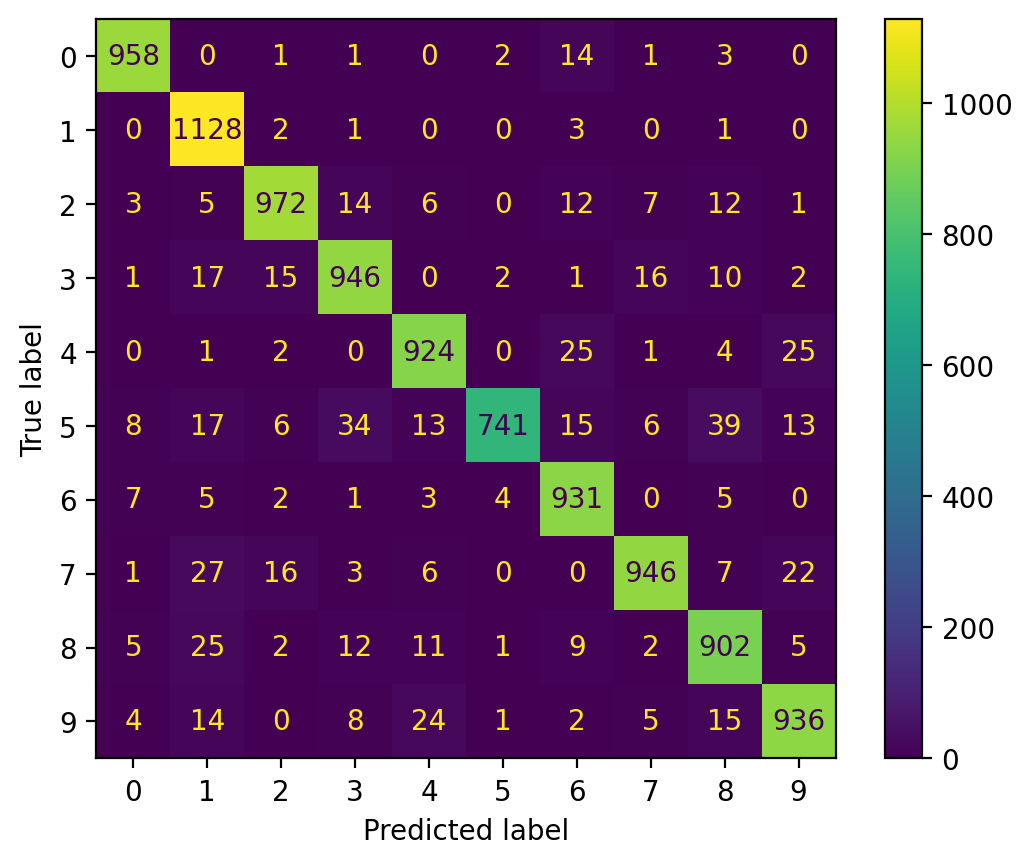

In [185]:
ConfusionMatrixDisplay(confusion_matrix(y_true_mlp, y_hat_mlp)).plot()
print("f1 score:", f1_score(y_true_mlp, y_hat_mlp, average='weighted'))
print("precision:", precision_score(y_true_mlp, y_hat_mlp, average='weighted'))
print("recall:", recall_score(y_true_mlp, y_hat_mlp, average='weighted'))
accuracy_score(y_true_mlp, y_hat_mlp)

- Logistic Regression

f1 score: 0.9259341439061143
precision: 0.9278117816042404
recall: 0.9237


0.9261

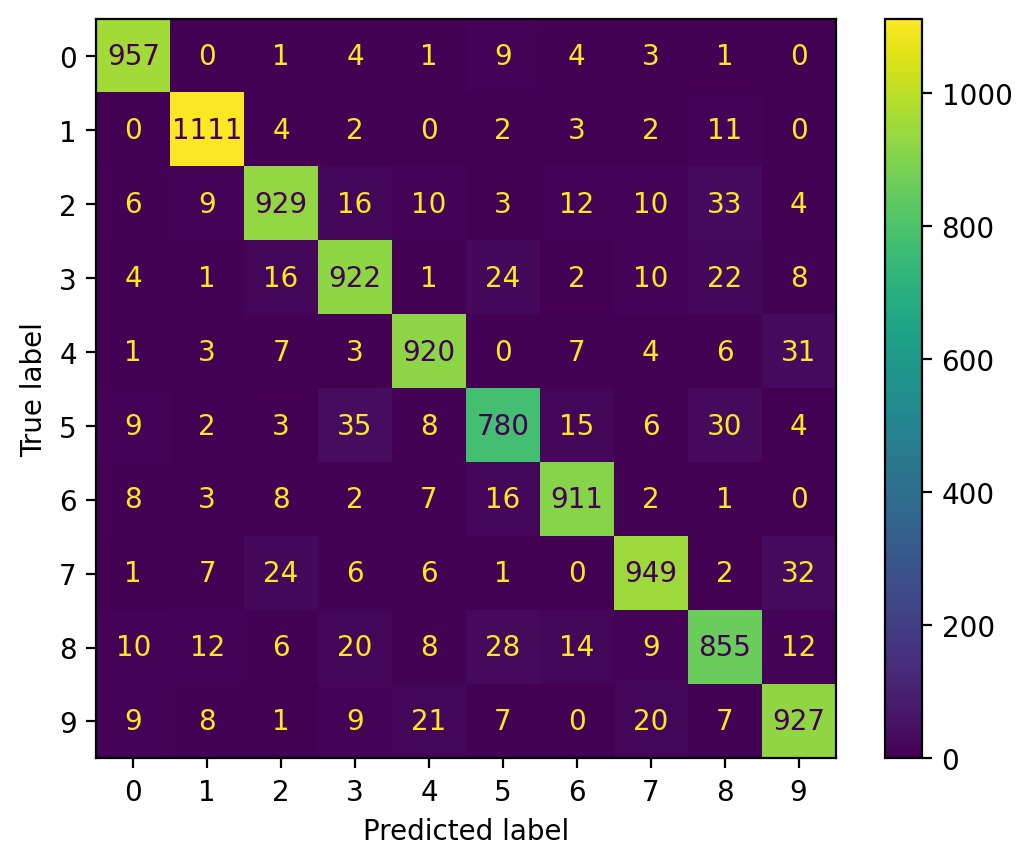

In [159]:
ConfusionMatrixDisplay(confusion_matrix(y_test, LR_predictions)).plot()
print("f1 score:", f1_score(y_test, LR_predictions, average='weighted'))
print("precision:", precision_score(y_true_mlp, y_hat_mlp, average='weighted'))
print("recall:", recall_score(y_true_mlp, y_hat_mlp, average='weighted'))
accuracy_score(y_test, LR_predictions)

- Random Forest

f1 score: 0.9511921626652323
precision: 0.9278117816042404
recall: 0.9237


0.9512

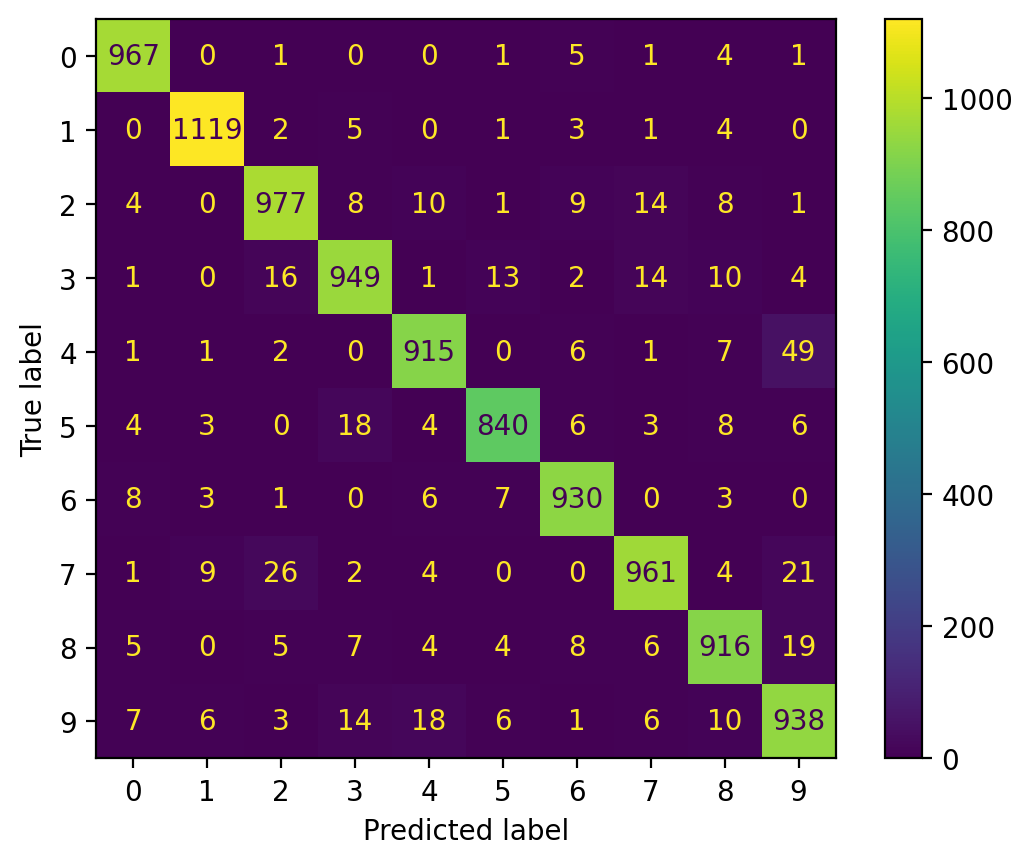

In [163]:
ConfusionMatrixDisplay(confusion_matrix(y_test, RF_predictions)).plot()
print("f1 score:", f1_score(y_test, RF_predictions, average='weighted'))
print("precision:", precision_score(y_true_mlp, y_hat_mlp, average='weighted'))
print("recall:", recall_score(y_true_mlp, y_hat_mlp, average='weighted'))
accuracy_score(y_test, RF_predictions)

### Fashion MNIST Dataset

In [166]:
# Load MNIST dataset
fashion_mnist_train = torchvision.datasets.FashionMNIST('fashion_mnist_datasets', train=True, transform=torchvision.transforms.ToTensor(), download=True)
fashion_mnist_test = torchvision.datasets.FashionMNIST('fashion_mnist_datasets', train=False, transform=torchvision.transforms.ToTensor(), download=True)

100%|██████████| 26421880/26421880 [00:11<00:00, 2288500.13it/s]


Extracting fashion_mnist_datasets/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion_mnist_datasets/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 3907173.42it/s]


Extracting fashion_mnist_datasets/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion_mnist_datasets/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2627081.60it/s]


Extracting fashion_mnist_datasets/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion_mnist_datasets/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4406587.14it/s]


Extracting fashion_mnist_datasets/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion_mnist_datasets/FashionMNIST/raw



In [170]:
y_hat, y_true = predict(model, fashion_mnist_test)
print("accuracy:", accuracy_score(y_true, y_hat))
print("f1 score:", f1_score(y_true, y_hat, average='weighted'))

100%|██████████| 10000/10000 [00:02<00:00, 3680.46it/s]

accuracy: 0.1002
f1 score: 0.07267643354168535


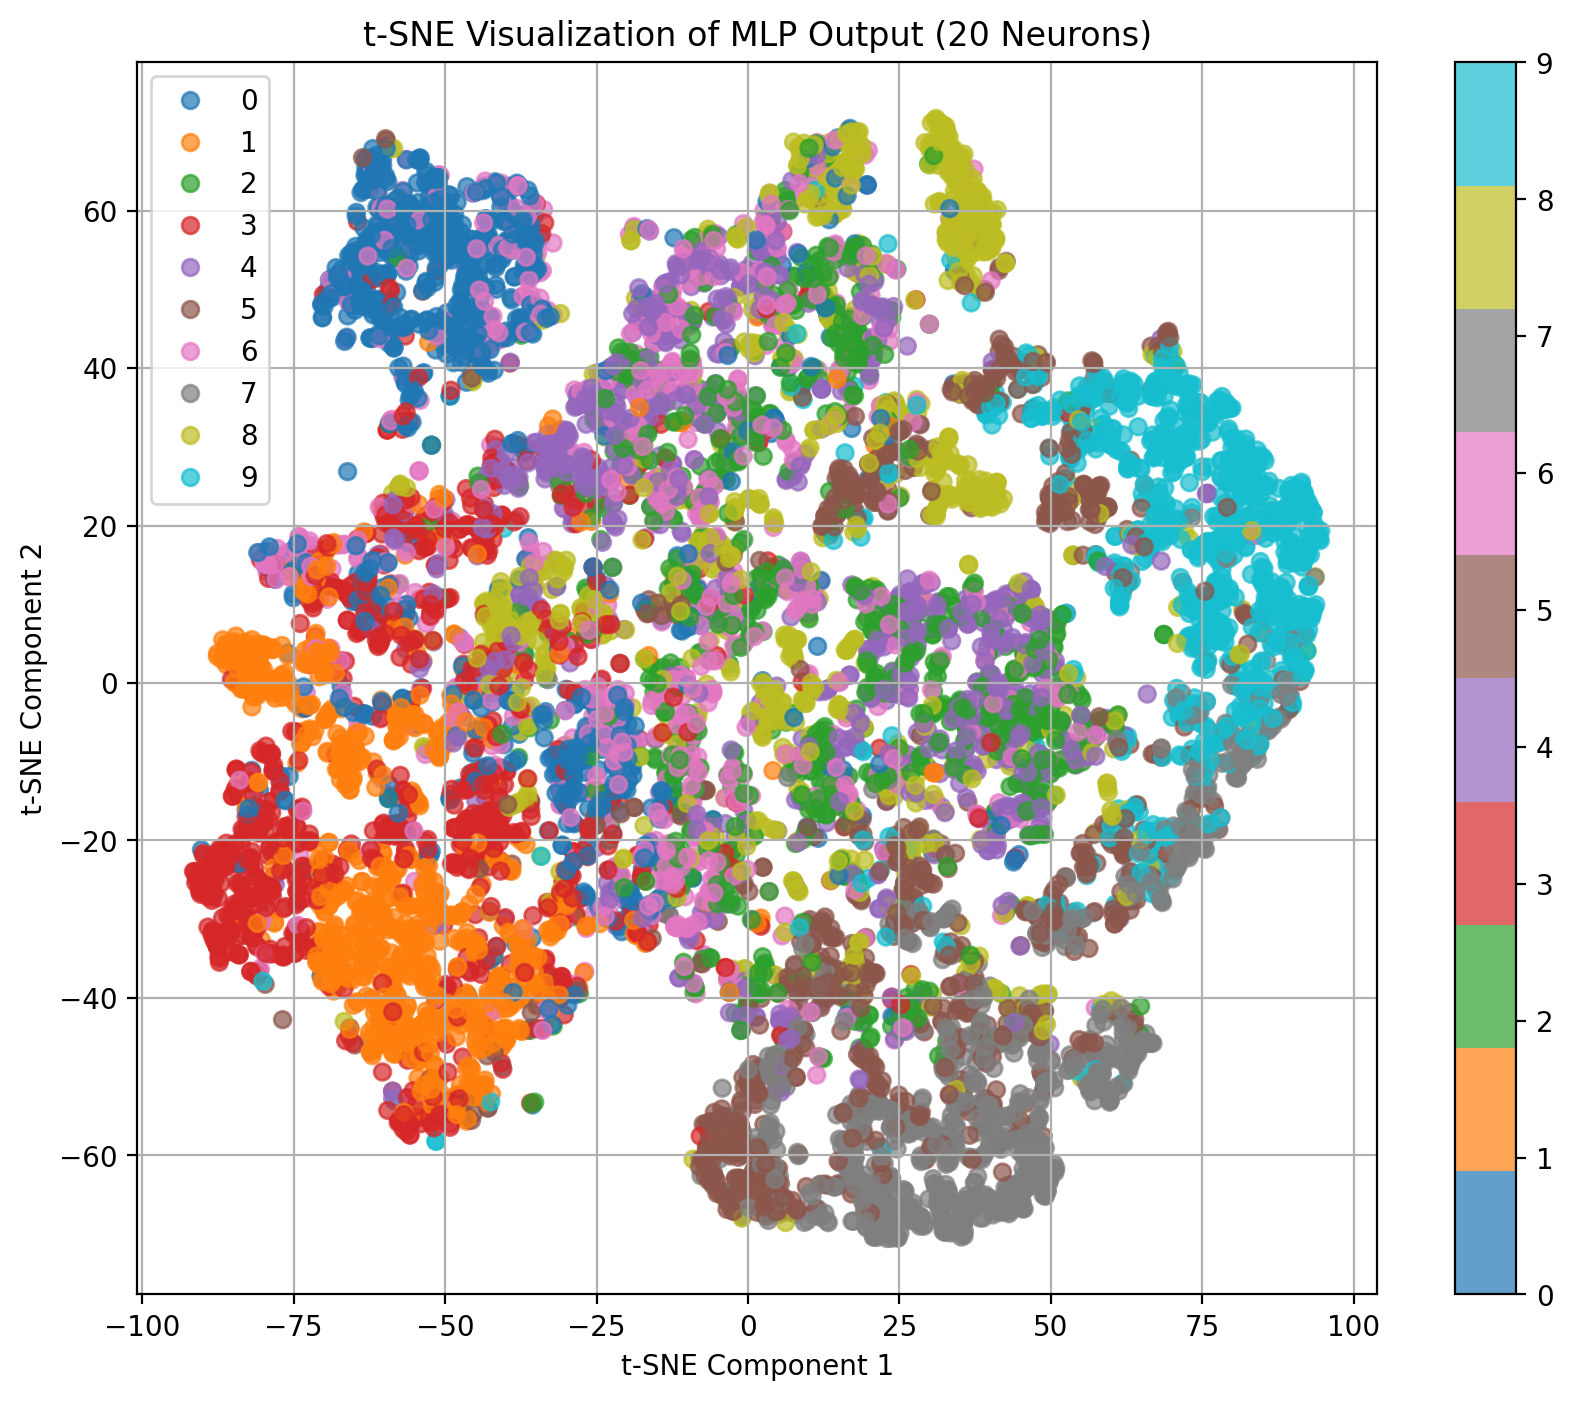

In [178]:
plot_TSNE(model, fashion_mnist_test)

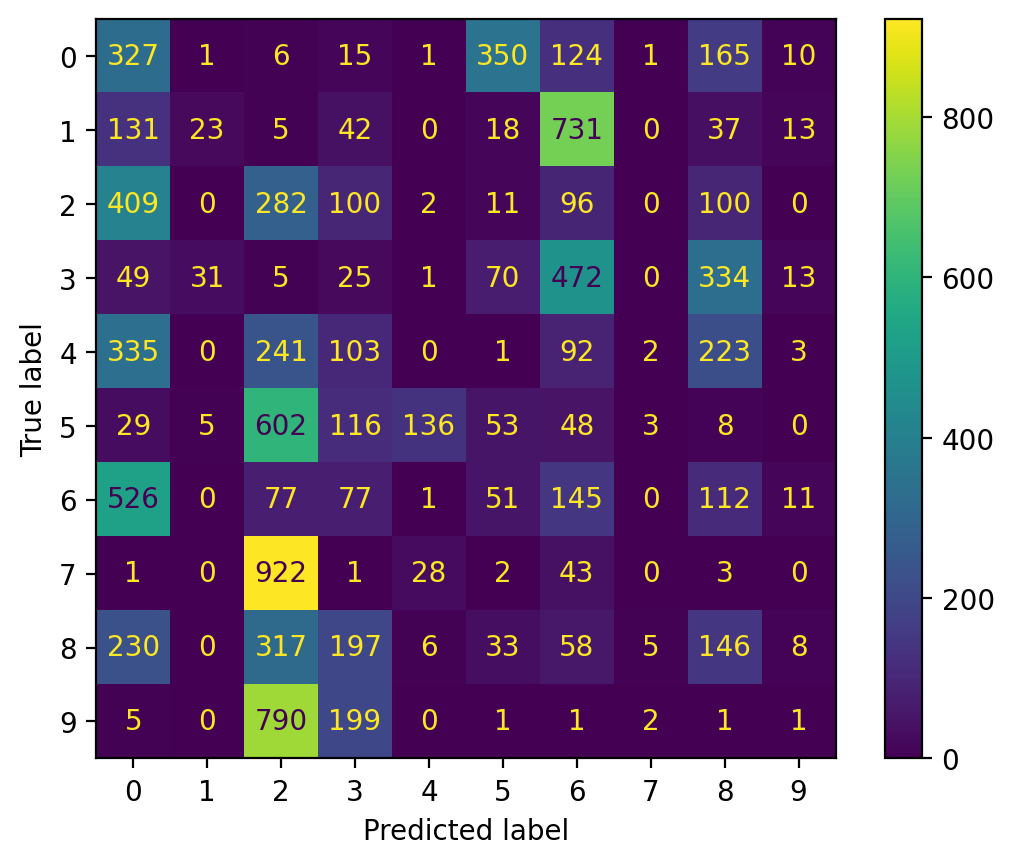

In [168]:
ConfusionMatrixDisplay(confusion_matrix(y_true, y_hat)).plot()

In [171]:
model_fashion_mnist = multiLayerPerceptron(ip_size=28*28, op_size=10, hidden_layer1=30, hidden_layer2=20)
model_fashion_mnist

multiLayerPerceptron(
  (lin1): Linear(in_features=784, out_features=30, bias=True)
  (lin2): Linear(in_features=30, out_features=20, bias=True)
  (lin3): Linear(in_features=20, out_features=10, bias=True)
)

In [172]:
fit(model_fashion_mnist, fashion_mnist_train, epochs=1, lr=0.001)

<-------------------------- epoch: 0--------------------------->


  0%|          | 0/60000 [00:00<?, ?it/s]


iter: 0 , training loss: 

  0%|          | 14/60000 [00:02<2:00:30,  8.30it/s]

tensor(2.2902, grad_fn=<DivBackward1>)


 33%|███▎      | 20066/60000 [01:00<01:29, 448.39it/s]


iter: 20000 , training loss: tensor(1.4612, grad_fn=<DivBackward1>)


 67%|██████▋   | 40051/60000 [01:51<01:01, 326.20it/s]


iter: 40000 , training loss: tensor(1.4614, grad_fn=<DivBackward1>)


100%|██████████| 60000/60000 [02:47<00:00, 358.77it/s]


In [173]:
y_hat_fashion, y_true_fashion = predict(model_fashion_mnist, fashion_mnist_test)
print("accuracy:", accuracy_score(y_true, y_hat))
print("f1 score:", f1_score(y_true, y_hat, average='weighted'))

100%|██████████| 10000/10000 [00:02<00:00, 3431.50it/s]

accuracy: 0.1002
f1 score: 0.07267643354168535


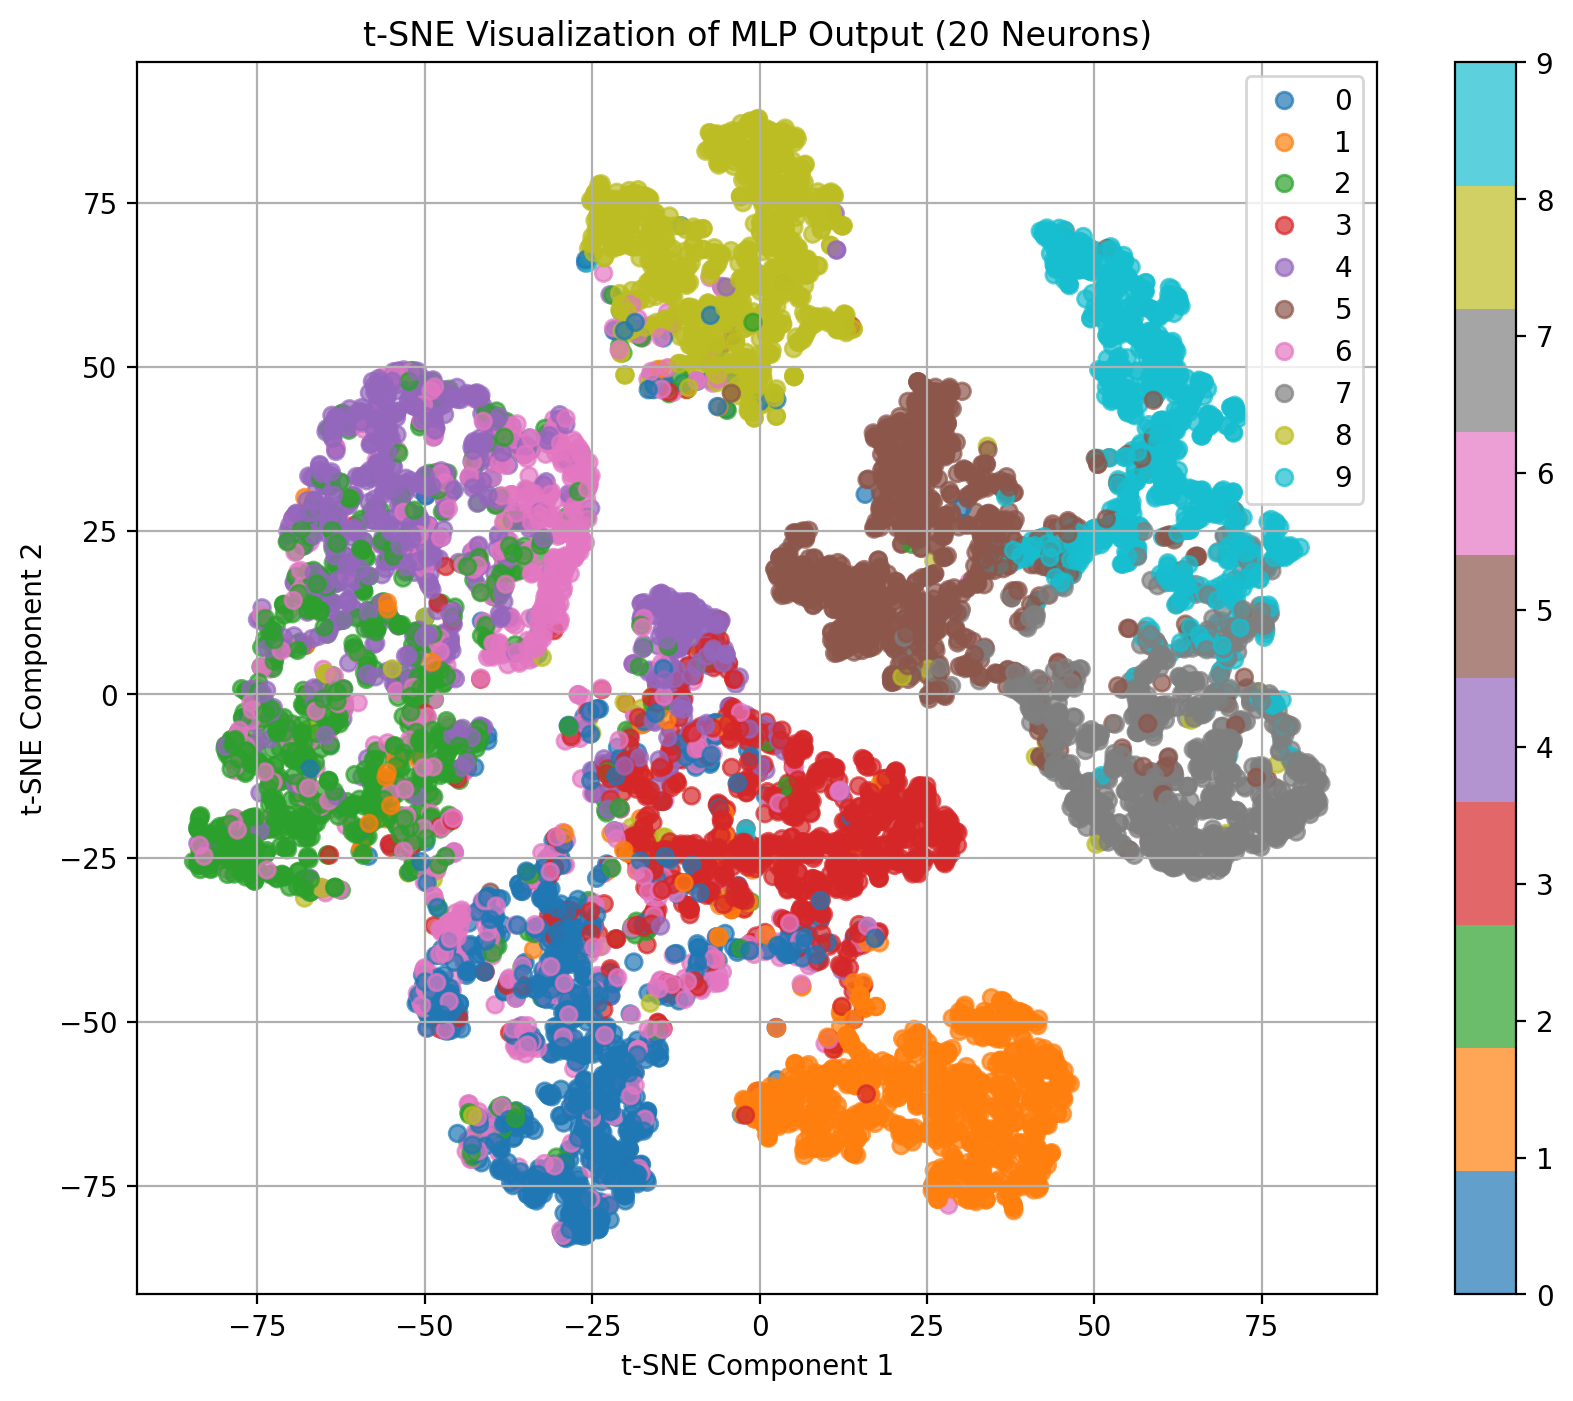

In [174]:
plot_TSNE(model_fashion_mnist, fashion_mnist_test)

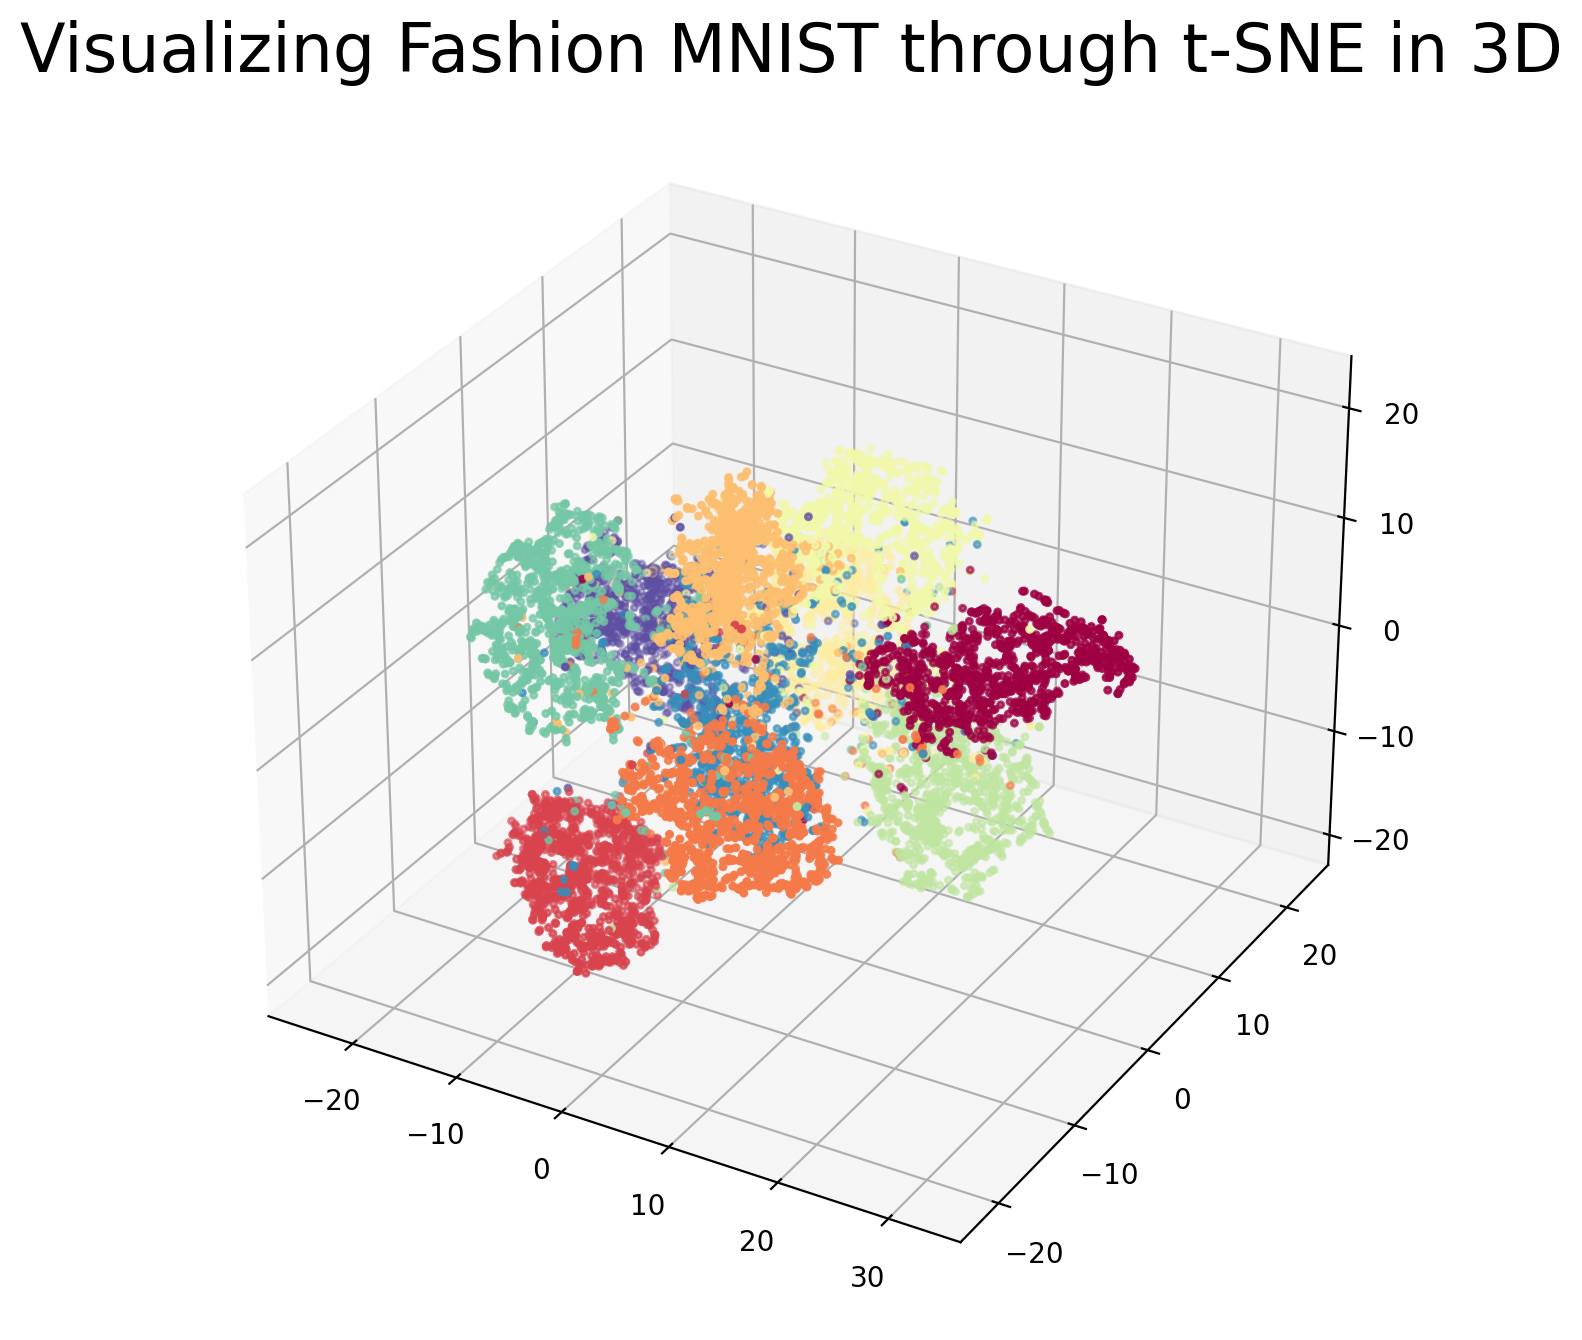

In [139]:
plot_TSNE_3D(model_fashion_mnist, fashion_mnist_test, text="Fashion")

### Validation

In [175]:
# Training the model on MNIST dataset
X_train_mlp, y_train_mlp = create_dataset(mnist_train)
mlp_model = MLPClassifier(hidden_layer_sizes=(28*28,30, 20, 10), max_iter=20, random_state=42)
mlp_model.fit(X_train_mlp, y_train_mlp)

/home/sahil/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(784, 30, 20, 10), max_iter=20,
              random_state=42)

In [176]:
X_test_mlp, y_test_mlp = create_dataset(mnist_test)
print("Accuracy on MNIST after fitting the model on MNIST:", accuracy_score(y_test, mlp_model.predict(X_test_mlp)))

Accuracy on MNIST after fitting the model on MNIST: 0.9779


In [177]:
X_test_fashion, y_test_fashion = create_dataset(fashion_mnist_test)
print("Accuracy on fashion MNIST after fitting the model on fashion MNIST:", accuracy_score(y_test_fashion, mlp_model.predict(X_test_fashion)))

Accuracy on fashion MNIST after fitting the model on fashion MNIST: 0.0773
